# Assignment 1: NARMA10 task
## TDNN

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
import keras_tuner as kt

2023-05-03 17:23:02.334940: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-03 17:23:02.384439: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-03 17:23:02.385043: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 17:23:03.372369: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Load the dataset

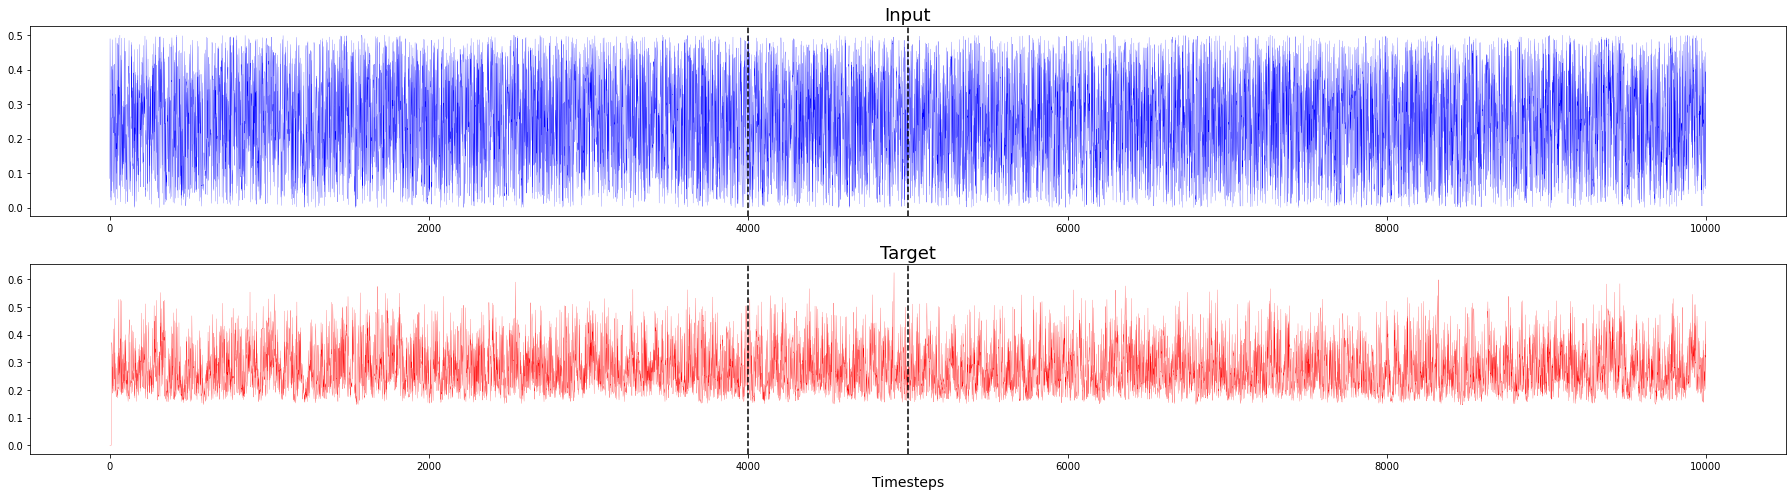

In [2]:
#load the data
x, y = np.loadtxt("NARMA10.csv", delimiter=",")


#split the dataset into training, validation and test
x_train = x[:4000]
x_valid = x[4000:5000] #validation
x_test = x[5000:]

y_train = y[:4000]
y_valid = y[4000:5000]
y_test = y[5000:]

#plot the data
t=np.arange(start=0,stop=len(x), step=1)
plt.figure(figsize = (25,7))
ax1 = plt.subplot(211)
plt.title('Input', fontsize=18)
ax1.plot(t,x, color = 'b', linewidth= 0.2)
ax1.axvline(x = 4000, color = 'black', linestyle= '--')
ax1.axvline(x = 5000, color = 'black', linestyle= '--')

ax2 = plt.subplot(212, sharex = ax1)
plt.title('Target', fontsize=18)
ax2.plot(t,y, color = 'r', linewidth = 0.2)
ax2.axvline(x = 4000, color = 'black', linestyle= '--')
ax2.axvline(x = 5000, color = 'black', linestyle= '--')
plt.xlabel('Timesteps', fontsize=14)
plt.tight_layout()

In [3]:
window_size = 10 #size of the window

Prepare the dataset to implement the tdnn:

In [4]:
# Prepare the input X and target Y in order to implement the tdnn
def get_XY(x, y, window):
    # Remove the first "window" elements from y array
    Y = y[window:]
    # X will be an array containing "len(Y)" arrays created using the sliding window
    X = []
    rows_x = len(Y)
    j = 0
    for i in range(rows_x):
        X = np.append(X,x[j:j+window])
        j = j + 1

    #reshape X so it can be fed to the Dense layer
    X =  np.reshape(X, (rows_x, 1, window)) 
    return X, Y 


#prepare the data
trainX, trainY = get_XY(x_train, y_train, window_size)
validX, validY = get_XY(x_valid, y_valid, window_size)
testX, testY = get_XY(x_test, y_test, window_size)

#check shape
print(trainX.shape,trainY.shape)

(3990, 1, 10) (3990,)


### Create the model
Actually we create the "hypermodel", defining the hyperparameter search space as well as the architecture of the model.

In [5]:
def model_architecture(hidden_units, activation, lr):
    model = Sequential()
    input_shape = (1, window_size) 
    model.add(Dense(units=hidden_units,input_shape=input_shape, activation='tanh'))
    model.add(Dense(units=1, activation=activation))

    # Tune the learning rate for the optimizer
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=lr),metrics=['mean_squared_error'])
    return model


def create_model(hp):

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 10-300
    hidden_units = hp.Int('units',  min_value=10, max_value=300, step=10)

    #Tune the activation function of the last layer
    activation = hp.Choice("activation", ["linear","relu"])

    # Tune the learning rate for the optimizer
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    # call model-building code with the hyperparameter values.
    model = model_architecture(
        hidden_units=hidden_units, activation=activation, lr=lr
    )
    return model


Instantiate hyperparameter tuner

In [6]:
# magari usare RandomSearch? 
'''
tuner = kt.Hyperband(create_model,
                     objective='val_mean_squared_error',
                     max_epochs=10,
                     factor=3,
                     directory='tuner',
                     project_name='tuner_kt',
                     overwrite=True
                     )
'''

tuner = kt.RandomSearch(
                     hypermodel =create_model,
                     objective='val_mean_squared_error',
                     max_trials=20,
                     overwrite=True,
                     directory='tuner',
                     project_name='tuner_kt'
                     )

summary of the search space:

In [7]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 300, 'step': 10, 'sampling': 'linear'}
activation (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'relu'], 'ordered': False}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


Create a callback to stop training early after reaching a certain value for the validation loss.

In [8]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [9]:
tuner.search(trainX, trainY, epochs=10, batch_size=1, validation_data = (validX, validY), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Completed hyperparameters search.\n
Otimal number of units of hidden layer = {best_hps.get('units')} \n
Optimal learning rate for the optimizer = {best_hps.get('lr')} \n
Optimal activation function for the last layer = {best_hps.get('activation')}
""")


Trial 20 Complete [00h 01m 23s]
val_mean_squared_error: 0.0012955080019310117

Best val_mean_squared_error So Far: 0.0005930315237492323
Total elapsed time: 00h 26m 16s
INFO:tensorflow:Oracle triggered exit



Completed hyperparameters search.

Otimal number of units of hidden layer = 10 

Optimal learning rate for the optimizer = 0.002816859726453112 

Optimal activation function for the last layer = relu



Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.

In [10]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2, validation_data = (validX, validY))

Epoch 1/50
3990/3990 - 13s - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - 13s/epoch - 3ms/step
Epoch 2/50
3990/3990 - 8s - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - 8s/epoch - 2ms/step
Epoch 3/50
3990/3990 - 9s - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - 9s/epoch - 2ms/step
Epoch 4/50
3990/3990 - 8s - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - 8s/epoch - 2ms/step
Epoch 5/50
3990/3990 - 7s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - 7s/epoch - 2ms/step
Epoch 6/50
3990/3990 - 7s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 9.4330e-04 - val_mean_squared_error: 9.4330e-04 - 7s/epoch - 2ms/step
Epoch 7/50
3990/3990 - 8s - loss: 8.7691e-04 - mean_squared_error: 8.7691e-04 - val_loss: 7.8449e-04 - val_mean_squared_error:

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1, 280)            3080      
                                                                 
 dense_3 (Dense)             (None, 1, 1)              281       
                                                                 
Total params: 3,361
Trainable params: 3,361
Non-trainable params: 0
_________________________________________________________________


In [ ]:
val_mse_per_epoch = history.history['val_mean_squared_error']
best_epoch = val_mse_per_epoch.index(min(val_mse_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 44


Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history = hypermodel.fit(trainX, trainY, epochs=best_epoch, batch_size=1, verbose=2, validation_data = (validX, validY)).history

Epoch 1/44
3990/3990 - 6s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - 6s/epoch - 1ms/step
Epoch 2/44
3990/3990 - 7s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0015 - val_mean_squared_error: 0.0015 - 7s/epoch - 2ms/step
Epoch 3/44
3990/3990 - 5s - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - 5s/epoch - 1ms/step
Epoch 4/44
3990/3990 - 5s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0015 - val_mean_squared_error: 0.0015 - 5s/epoch - 1ms/step
Epoch 5/44
3990/3990 - 5s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0015 - val_mean_squared_error: 0.0015 - 5s/epoch - 1ms/step
Epoch 6/44
3990/3990 - 5s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0014 - val_mean_squared_error: 0.0014 - 5s/epoch - 1ms/step
Epoch 7/44
3990/3990 - 5s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0015 - val_mean_squared_error: 0.0015 - 5s/epoch - 1

### Make plots of the loss and validation loss

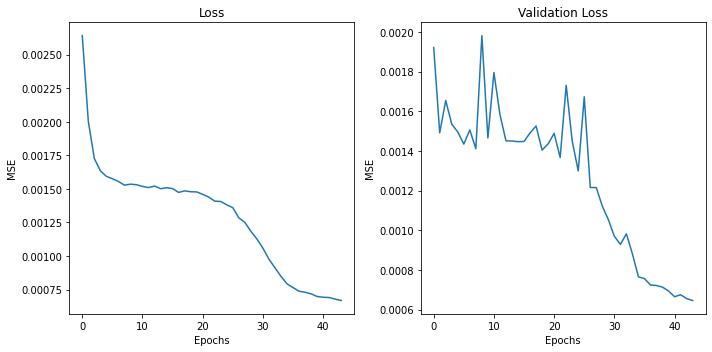

In [ ]:
plt.figure(figsize = (10,5))

plt.subplot(121)
plt.plot(history['loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.subplot(122)
plt.plot(history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.tight_layout()
plt.show()

In [ ]:
hypermodel.save('keras_model_tdnn')


2023-05-03 16:12:08.128768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_4_input' with dtype float and shape [?,1,10]
	 [[{{node dense_4_input}}]]
2023-05-03 16:12:08.165385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_4_input' with dtype float and shape [?,1,10]
	 [[{{node dense_4_input}}]]
2023-05-03 16:12:08.178846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,10]
	 [[{{n

INFO:tensorflow:Assets written to: keras_model_tdnn/assets


INFO:tensorflow:Assets written to: keras_model_tdnn/assets


In [ ]:
hypermodel = keras.models.load_model('keras_model_tdnn')

### Plots of target and output signals over time

4990/4990 [==============================] - 6s 1ms/step - loss: 6.0047e-04 - mean_squared_error: 6.0047e-04


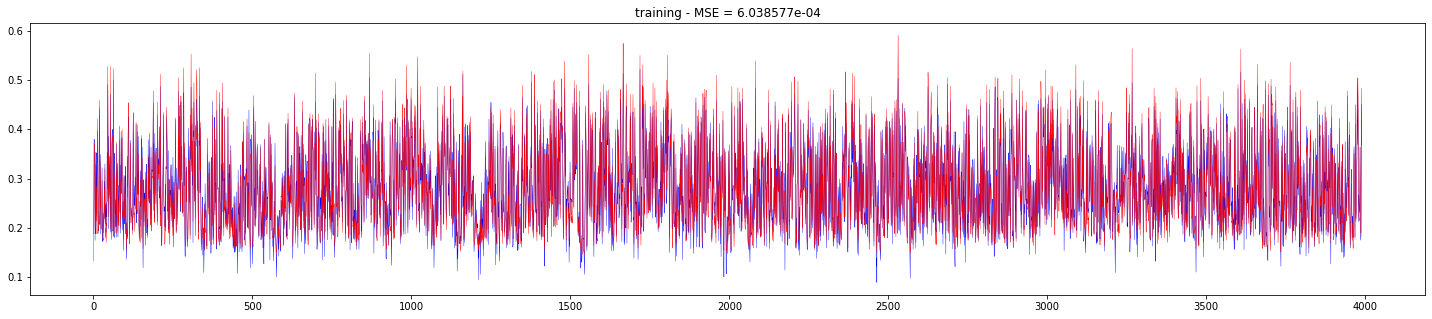

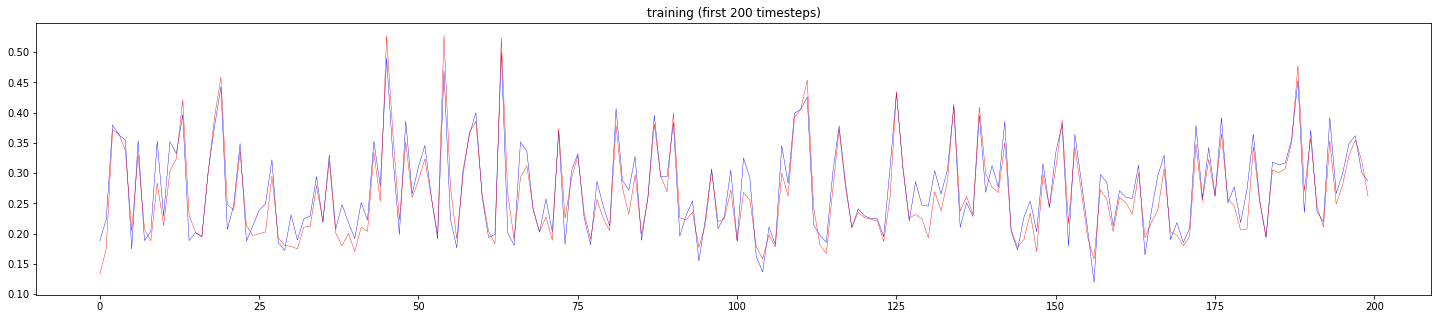

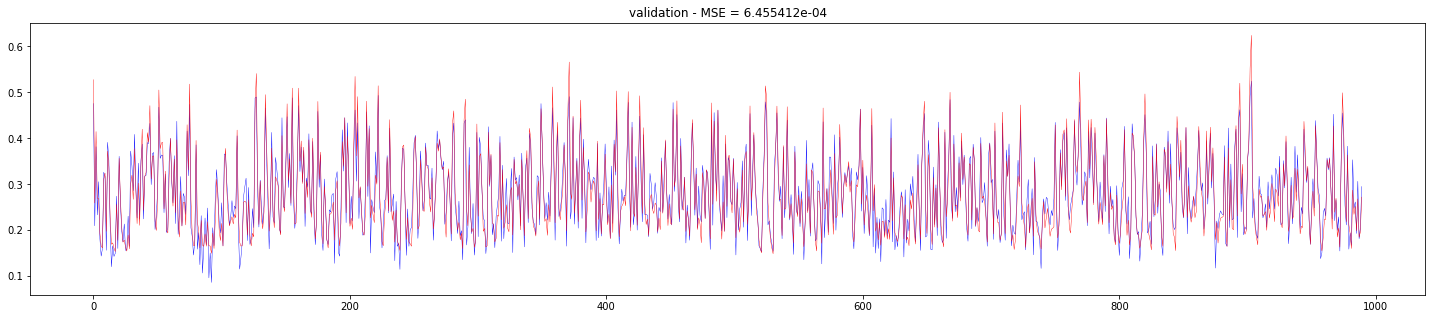

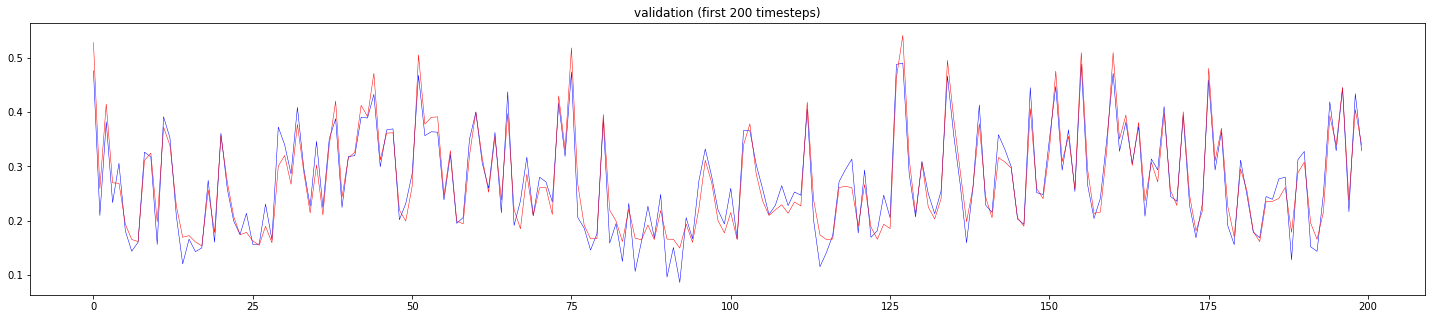

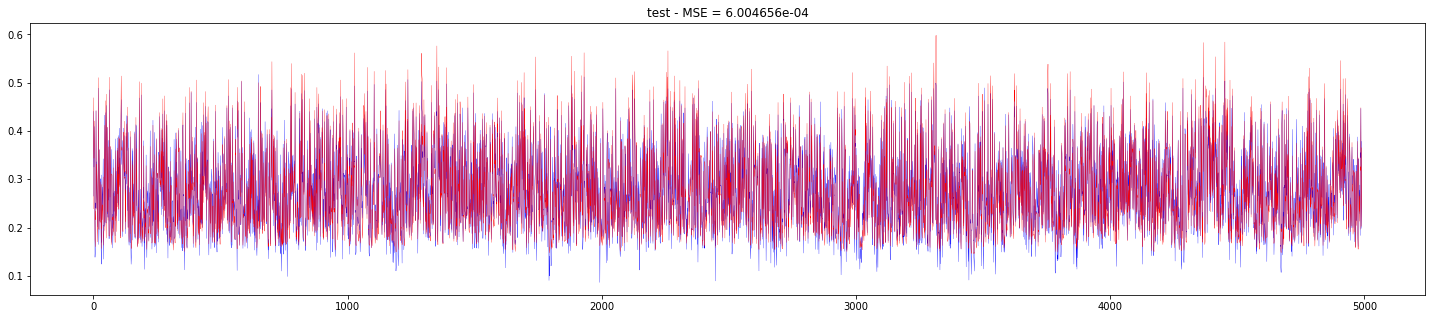

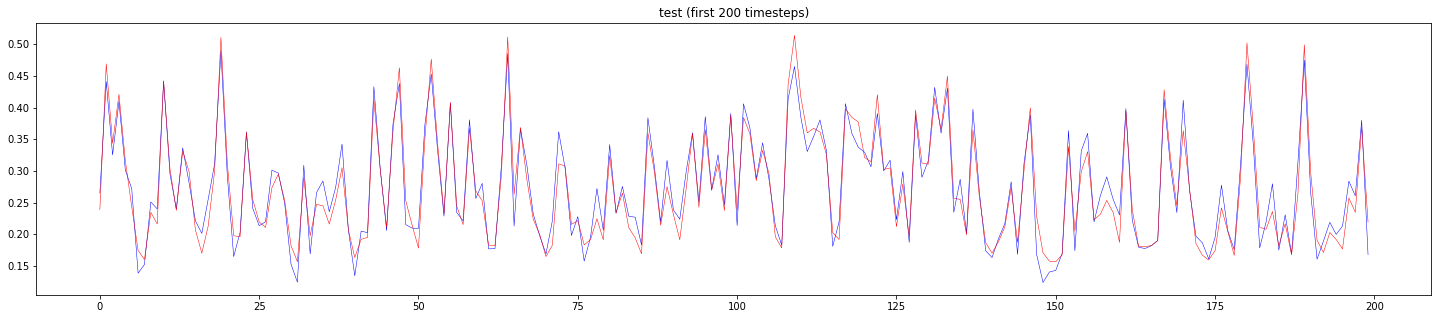

In [ ]:
#training

y = hypermodel.predict(trainX)
mse = hypermodel.evaluate(trainX, trainY, batch_size=1)[0]
t=np.arange(start=0,stop=len(y), step=1)
plt.figure(figsize = (25,5))
plt.title(f'training - MSE = {mse:e}')
plt.plot(t,y.ravel(), color = 'b', linewidth= 0.4)
plt.plot(t,trainY.ravel(), color = 'r', linewidth= 0.4)

plt.figure(figsize = (25,5))
plt.title('training (first 200 timesteps)')
plt.plot(t[:200],y.ravel()[:200], color = 'b', linewidth= 0.4)
plt.plot(t[:200],trainY.ravel()[:200], color = 'r', linewidth= 0.4)

#validation

y = hypermodel.predict(validX)
mse = hypermodel.evaluate(validX, validY, batch_size=1)[0]
t=np.arange(start=0,stop=len(y), step=1)
plt.figure(figsize = (25,5))
plt.title(f'validation - MSE = {mse:e}')
plt.plot(t,y.ravel(), color = 'b', linewidth= 0.4)
plt.plot(t,validY.ravel(), color = 'r', linewidth= 0.4)

plt.figure(figsize = (25,5))
plt.title('validation (first 200 timesteps)')
plt.plot(t[:200],y.ravel()[:200], color = 'b', linewidth= 0.5)
plt.plot(t[:200],validY.ravel()[:200], color = 'r', linewidth= 0.5)

#test

y = hypermodel.predict(testX)
mse = hypermodel.evaluate(testX, testY, batch_size=1)[0]
t=np.arange(start=0,stop=len(y), step=1)
plt.figure(figsize = (25,5))
plt.title(f'test - MSE = {mse:e}')
plt.plot(t,y.ravel(), color = 'b', linewidth= 0.3)
plt.plot(t,testY.ravel(), color = 'r', linewidth= 0.3)

plt.figure(figsize = (25,5))
plt.title('test (first 200 timesteps)')
plt.plot(t[:200],y.ravel()[:200], color = 'b', linewidth= 0.5)
plt.plot(t[:200],testY.ravel()[:200], color = 'r', linewidth= 0.5)

